# Plotting 2D Gradient Vector Field of Electrostatic Density 

## Introduction
This notebook is meant to visualize the 2 dimensional gradient vector field of the electronic density of the provided molecule

## Dependencies

1. [numpy](https://numpy.org/doc/stable/)
2. [matplotlib ](https://matplotlib.org/stable/contents.html)
3. [Chemtools](https://chemtools.org/usr_doc_installation.html) 

## Obtaining XYZ coordinates

We use the chemtools call `mol.coordinates` to obtain the XYZ cartesian coordinates of our molecule, in this example, dichloropyrimidine. 

In [102]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D  # Need this to plot in 3D

from chemtools import Molecule

mol = Molecule.from_file("dichloropyridine26_q+0.fchk")
coord = mol.coordinates

print("XYZ Coordinates: ")
print(coord)



Initialized: <horton.gbasis.cext.GOBasis object at 0x7f497e3cdfa0>
  Number of basis functions         : 219
  Number of normalization constants : 453
  Maximum shell type                : 2
  Center     0 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     1 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     2 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     3 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     4 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     5 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     6 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     7 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     8 :  S3 S1 S1 P1 P1
  Center     9 :  S3 S1 S1 P1 P1
  Center    10 :  S3 S1 S1 P1 P1

XYZ Coordinates: 
[[-4.95130924e+00  2.31173977e+00 -2.64561659e-04]
 [ 4.95149821e+00  2.31139962e+00  2.07869875e-04]
 [ 7.55890453e-05  1.84250188e+00 -1.88972613e-05]
 [-9.44863066e-05 -3.41775868e+00  1.13383568e-04]
 [-2.28277027e+00 -2.09580077e+00 -1.88972613e-05]
 [ 2.28267578e+00 -2.09595195e+00  1.70075352e-0

## Rotate and Scale Operation

We wish to force the molecular to be planar, we accomplish this using numpy's linear algebra capabilities, more specifically rotation and scaling operations. 

First, we use `np.cross()` to perform a cross product and `np.linalg.norm()` on our coordinates to generate an orthonormal set. 

Then, we have to perform our rotation operation
```
cos(x)) + a^2 * (1-cos(x)      a*u*(1-cos(x)      u*sin(x)

a * u *(1-cos(x))           cos(x) + u^2 *(1-cos(x))   -a *sin(x)

-u * sin(x)                 a * sin(x)              cos(x) 
```



In [103]:
coord1 = coord[0] 
coord2 = coord[1]
coord3 = coord[2]

v1, v2 = coord2 - coord1, coord3 - coord1
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)

a, b, c = normal
cos_theta = c
sin_theta = np.sqrt(a**2.0 + b**2.0)
u_1 = b / np.sqrt(a**2.0 + b**2.0)
u_2 = -a / np.sqrt(a**2.0 + b**2.0)
rot = np.array([
    [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
    [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
    [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
])


## Plot our rotated coordinates

## Generate a Grid

To eventually plot our gradient vector field, we must initialize a "grid" with several points. Originally in 2D space, this will later be rotate back into 3D space

In [104]:
rot_coords = np.dot(rot, (coord - coord[0]).T).T


l_bnd = np.min(rot_coords, axis=0) - 1
u_bnd = np.max(rot_coords, axis=0) + 1
print(l_bnd)
step_size = 0.3
x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)



[-11.15737795  -4.13120126  -1.00005684]


## Generating a Corresponding Affine Plane

We now must plot our coordinates on the grid plane generated below.

In [105]:
# Add zero z-axis and rotate it and translate it to the plane
grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
assert np.all(np.abs(np.dot(grid_plane, normal)) < 1e-5)
grid_plane += coord[0]


## Computing Gradient and Plotting  the Gradient Vector Field 

The gradient vector is a column vector of the partial derivative of each variable in a system. In the context of electron density of a molecule, the gradient vectors will become increasingly positive as one approaches individual atoms or functional groups that have a higher electrostatic potential, such as halogens or carboxylic acids.

### Computing

We use Chemtools `compute_gradient()` function on our input molecule and our previously generated grid plane to create our gradient vectors

We then to perform a projection, which is the dot product of the computed gradients and the orthonormal vectors subtracted from the computed gradient vectors.

### Plotting

We wish to visualize this in 2 dimensional cartesian space, which is accomplished by performing the dot product on our projection (`proj_gradients`) and our orthonormal vector. 



In [106]:
gradients = mol.compute_gradient(grid_plane)
print(gradients)

proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
# Make sure it is on the plane by making sure it is orthogonal to the normal.
assert np.all(np.dot(proj_gradients, normal) < 1e-5)
# Rotate the projected gradients onto two-dimensions.
rot_proj_gradients = np.dot(rot, proj_gradients.T).T
assert np.all(np.abs(rot_proj_gradients[:, 2]) < 1e-8)

[[ 1.70982687e-05  5.10868096e-04 -6.55691344e-09]
 [-2.04658254e-05  8.72965114e-04 -1.29942129e-08]
 [-1.34014657e-04  1.43885163e-03 -2.51374698e-08]
 ...
 [ 3.92944438e-08 -8.98940297e-06  1.84799988e-10]
 [ 3.01288771e-09 -6.67502749e-06  1.34390522e-10]
 [ 4.24791253e-09 -4.95304702e-06  9.83619427e-11]]


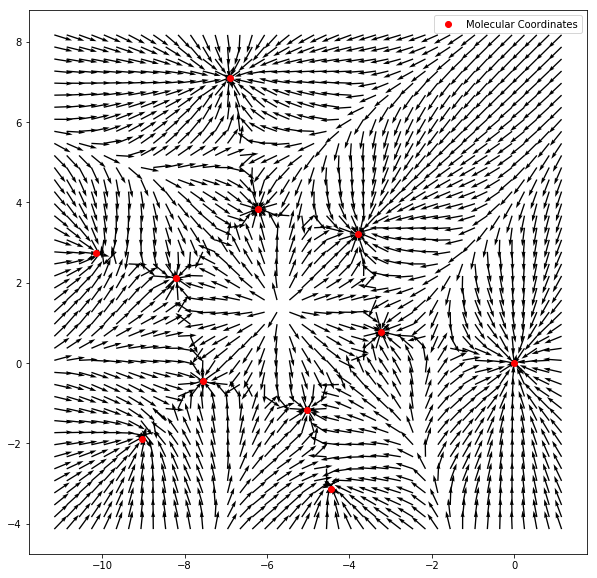

In [107]:
# Rotate Projected Plane.
rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
plt.figure(figsize=(10,10))
plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1],color='black', scale=30)
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.show()

In [108]:
print(rot_proj_gradients[:,1])
print(grid_2d)

[ 0.72091656  0.68034089  0.62785585 ... -0.69419164 -0.69700773
 -0.69671635]
[[-11.15737795  -4.13120126]
 [-11.15737795  -3.83120126]
 [-11.15737795  -3.53120126]
 ...
 [  1.14262205   7.56879874]
 [  1.14262205   7.86879874]
 [  1.14262205   8.16879874]]


## Generation of a Contour Plot 

Contour plots convert a 3D function to 2D and are usued to represent the change in a specific axis given the other variables are held constant. Each contour line is a *level curve* which represents points that share the same z coordinate. 

In [53]:
coord1 = coord[0] 
coord2 = coord[1]
coord3 = coord[2]

v1, v2 = coord2 - coord1, coord3 - coord1
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)


'''
x= grid_2d[:,0]
y = grid_2d[:,1]
X, Y = np.meshgrid(x, y)
Z = mol.compute_density(grid_plane)
gradients = Z
proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal

print(Z)


plt.figure(figsize=(10,10))
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.contour(X,Y,Z)
#plt.contourf(X,Y,Z, cmap='Reds')

plt.show()
'''

'\nx= grid_2d[:,0]\ny = grid_2d[:,1]\nX, Y = np.meshgrid(x, y)\nZ = mol.compute_density(grid_plane)\ngradients = Z\nproj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal\n\nprint(Z)\n\n\nplt.figure(figsize=(10,10))\nplt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")\nplt.legend()\nplt.contour(X,Y,Z)\n#plt.contourf(X,Y,Z, cmap=\'Reds\')\n\nplt.show()\n'

In [203]:
def plotVectorFieldOverPlane(coord1,coord2,coord3,vectorFunc,step_size=0.32, title=''):
    """
    PARAMETERS
    
    coord1 : np.ndarray(3,)
        First point on plane 
        
    coord2 : np.ndarray(3,) 
        Second Point on plane
    
    coord3 : np.ndarray(3,)
        Third Point on Plane
    
    vectorFunct : callabel() 
        Vector Field that inputs 3D point to 3D point 
    
    stepSize : float
        Step Size of 2D Affine Grid
    
    title : str
        Title
    
    color : str
        Color of Gradient Arrows  
        
    """

    v1, v2 = coord2 - coord1, coord3 - coord1
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)

    a, b, c = normal
    
    def _rotate_3d(normal):
        """
        This function is intended to consolitate the rotate 
        and scale operation of the matrix
        """
        a,b,c = normal
        cos_theta = c
        sin_theta = np.sqrt(a**2.0 + b**2.0)
        u_1 = b / np.sqrt(a**2.0 + b**2.0)
        u_2 = -a / np.sqrt(a**2.0 + b**2.0)
        rot = np.array([
            [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
            [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
            [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
            
            
        return rot
    _rotate_3d(normal)
    rot_coords = np.dot(rot, (coord - coord[0]).T).T


    l_bnd = np.min(rot_coords, axis=0) - 1
    u_bnd = np.max(rot_coords, axis=0) + 1
    print(l_bnd)
    
    x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
    y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
    grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)

    # Add zero z-axis and rotate it and translate it to the plane
    grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
    grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
    grid_plane += coord[0]
    
    vectorFunc = mol.compute_gradient(grid_plane)
    gradients = vectorFunc
    print(gradients)

    proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
    rot_proj_gradients = np.dot(rot, proj_gradients.T).T
    
    # Rotate Projected Plane.
    rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
    plt.figure(figsize=(10,10))
    plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1],color='black', scale=40)
    plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
    plt.legend()
    
    plt.title(title)
    plt.show()

    
    

SyntaxError: invalid syntax (<ipython-input-203-f6f065868fc4>, line 45)

[-11.15737795  -4.13120126  -1.00005684]
[[ 1.70982687e-05  5.10868096e-04 -6.55691344e-09]
 [-1.04931053e-05  7.99884048e-04 -1.16055706e-08]
 [-8.37508916e-05  1.22474323e-03 -2.02612834e-08]
 ...
 [ 3.37264489e-08 -9.01586420e-06  1.84176696e-10]
 [ 3.25398635e-09 -7.02805652e-06  1.41053402e-10]
 [ 2.07112074e-09 -5.47775577e-06  1.08597246e-10]]


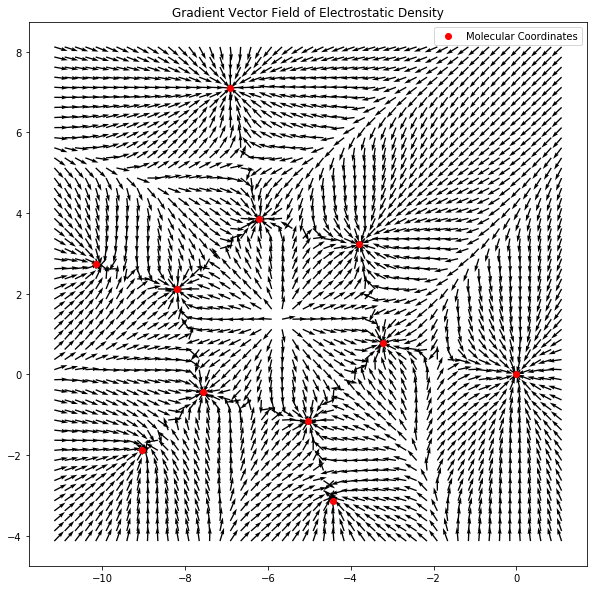

In [55]:
plotVectorFieldOverPlane(coord[0],coord[1],coord[2],vectorFunc = mol.compute_gradient(grid_plane),step_size=0.25, title='Gradient Vector Field of Electrostatic Density')

In [56]:
scalar_func = ''
levels = 1
coord1 = coord[0]
coord2 = coord[1]
coord3 = coord[2]
def PlotContourOverPlane(coord1,coord2,coord3,scalar_func, levels, step_size=0.5):
    coord1 = coord[0] 
    coord2 = coord[1]
    coord3 = coord[2]
    
    
    
PlotContourOverPlane(coord1,coord2,coord3,scalar_func, levels, step_size=0.5)

In [12]:

electroDensity = mol.compute_density(grid_plane)
print(electroDensity)

[2.17212008e-04 3.59387779e-04 5.82559952e-04 ... 6.25544026e-06
 4.63270562e-06 3.42546710e-06]


In [199]:
coord1 = coord[0]
coord2 = coord[1]
coord3 = coord[2]


v1, v2 = coord1 - coord3, coord2 - coord3
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)

a, b, c = normal
def _get_rotation_matrix_to_xy_plane(normal): 
    """
    This function is designed to consolidate a 2D rotate 
    operation, returning rot, which can then be used 
    to determine the rotated coordinates by computing the dot 
    product 
    """
    a,b,c = normal
    costheta = c
    sintheta = np.sqrt(a**2.0 + b**2.0)
    x = u_1 = b / np.sqrt(a**2.0 + b**2.0)
    y = u_2 = -a / np.sqrt(a**2.0 + b**2.0)

    cos, sin = np.cos(costheta), np.sin(sintheta)
    rot = np.matrix([[cos, sin], [-sin, cos]])

    return rot
_get_rotation_matrix_to_xy_plane(normal)
print(rot)

rot_coords = np.dot(rot, (coord - coord[0]).T).T

l_bnd = np.min(rot_coords, axis=0) - 1
u_bnd = np.max(rot_coords, axis=0) + 1

x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)


grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
grid_plane += coord[0]
print("grid plane")
print(grid_plane)

x = grid_plane[:,0]
y = grid_plane[:,1]
scalarFunc = mol.compute_density(grid_plane)
scalarFuncPlot = np.array(scalarFunc)

#proj = (np.dot(x, y) / np.linalg.norm(y))
scalarFuncPlot = np.broadcast_to((scalarFuncPlot*scalarFuncPlot).sum(-1)[...,None], scalarFuncPlot.shape)

proj = np.dot(scalarFuncPlot,normal).reshape(-1,1)
rotProj = np.dot(rot,proj.T).T

rotProj /=np.linalg.norm(rotProj,axis=1).reshape((-1,1))
scalarFuncPlot = np.array(scalarFunc)
proj_density = scalarFunc - np.dot(scalarFunc, proj)[:, np.newaxis] * proj
print(proj_density)


#scalarFuncPlot = scalarFuncPlot.reshape(len(x),len(y))
#levels = np.array([0.001 * n * n for n in range(1)])
levels = 1
#plt.contour(x,y,scalarFuncPlot,levels)
plt.show()

[[-6.97331320e-01  7.16748929e-01 -4.77061362e-05]
 [ 7.16748929e-01  6.97331321e-01  2.01453432e-05]
 [ 4.77061362e-05 -2.01453432e-05 -9.99999999e-01]]
grid plane
[[-1.31954229e-01 -8.56611497e+00  1.84489266e-04]
 [ 8.30704494e-02 -8.35691557e+00  1.90532869e-04]
 [ 2.98095128e-01 -8.14771618e+00  1.96576472e-04]
 ...
 [-3.23166990e-01  8.40867332e+00 -1.66595694e-04]
 [-1.08142311e-01  8.61787272e+00 -1.60552091e-04]
 [ 1.06882368e-01  8.82707212e+00 -1.54508488e-04]]


ValueError: shapes (1764,) and (3,) not aligned: 1764 (dim 0) != 3 (dim 0)

In [185]:
gradient = mol.compute_gradient(grid_plane)
print(gradient)
print(scalarFunc)

[[ 1.70982687e-05  5.10868096e-04 -6.55691344e-09]
 [-2.04658254e-05  8.72965114e-04 -1.29942129e-08]
 [-1.34014657e-04  1.43885163e-03 -2.51374698e-08]
 ...
 [ 3.92944438e-08 -8.98940297e-06  1.84799988e-10]
 [ 3.01288771e-09 -6.67502749e-06  1.34390522e-10]
 [ 4.24791253e-09 -4.95304702e-06  9.83619427e-11]]
[2.17212008e-04 3.59387779e-04 5.82559952e-04 ... 6.25544026e-06
 4.63270562e-06 3.42546710e-06]
